# CART - Decision Tree Classification

### Step 1 - Import libraries

In [4]:
import pandas as pd # for data manipulation
import numpy as np # for data manipulation

from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn import tree # for decision tree models

import plotly.express as px  # for data visualization
import plotly.graph_objects as go # for data visualization
import graphviz # for plotting decision tree graphs

# Other utilities
import sys
import os

# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])

### Step 2 - Get the weather data for our model (from Kaggle)
- Donwload from: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package
- After downloading it, we read csv into a Pandas dataframe

In [5]:
# Set Pandas options to display more columns
pd.options.display.max_columns=50

# Read in the weather data csv
df=pd.read_csv(main_dir+'/data/weatherAUS.csv', encoding='utf-8')

# Drop records where target RainTomorrow=NaN
df=df[pd.isnull(df['RainTomorrow'])==False]

# For other columns with missing values, fill them in with column mean
df=df.fillna(df.mean())

# Create a flag for RainToday and RainTomorrow, note RainTomorrowFlag will be our target variable
df['RainTodayFlag']=df['RainToday'].apply(lambda x: 1 if x=='Yes' else 0)
df['RainTomorrowFlag']=df['RainTomorrow'].apply(lambda x: 1 if x=='Yes' else 0)

# Show a snaphsot of data
df

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6     5.469824   
1       2008-12-02   Albury      7.4     25.1       0.0     5.469824   
2       2008-12-03   Albury     12.9     25.7       0.0     5.469824   
3       2008-12-04   Albury      9.2     28.0       0.0     5.469824   
4       2008-12-05   Albury     17.5     32.3       1.0     5.469824   
...            ...      ...      ...      ...       ...          ...   
145454  2017-06-20    Uluru      3.5     21.8       0.0     5.469824   
145455  2017-06-21    Uluru      2.8     23.4       0.0     5.469824   
145456  2017-06-22    Uluru      3.6     25.3       0.0     5.469824   
145457  2017-06-23    Uluru      5.4     26.9       0.0     5.469824   
145458  2017-06-24    Uluru      7.8     27.0       0.0     5.469824   

        Sunshine WindGustDir  WindGustSpeed WindDir9am WindDir3pm  \
0       7.624853           W           44.0          W        WNW   
1       7.624853         WNW           44.0        NNW        WSW   
2       7.624853         WSW           46.0          W        WSW   
3       7.624853          NE           24.0         SE          E   
4       7.624853           W           41.0        ENE         NW   
...          ...         ...            ...        ...        ...   
145454  7.624853           E           31.0        ESE          E   
145455  7.624853           E           31.0         SE        ENE   
145456  7.624853         NNW           22.0         SE          N   
145457  7.624853           N           37.0         SE        WNW   
145458  7.624853          SE           28.0        SSE          N   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
0               20.0          24.0         71.0         22.0       1007.7   
1                4.0          22.0         44.0         25.0       1010.6   
2               19.0          26.0         38.0         30.0       1007.6   
3               11.0           9.0         45.0         16.0       1017.6   
4                7.0          20.0         82.0         33.0       1010.8   
...              ...           ...          ...          ...          ...   
145454          15.0          13.0         59.0         27.0       1024.7   
145455          13.0          11.0         51.0         24.0       1024.6   
145456          13.0           9.0         56.0         21.0       1023.5   
145457           9.0           9.0         53.0         24.0       1021.0   
145458          13.0           7.0         51.0         24.0       1019.4   

        Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm RainToday  \
0            1007.1  8.000000  4.503167     16.9     21.8        No   
1            1007.8  4.437189  4.503167     17.2     24.3        No   
2            1008.7  4.437189  2.000000     21.0     23.2        No   
3            1012.8  4.437189  4.503167     18.1     26.5        No   
4            1006.0  7.000000  8.000000     17.8     29.7        No   
...             ...       ...       ...      ...      ...       ...   
145454       1021.2  4.437189  4.503167      9.4     20.9        No   
145455       1020.3  4.437189  4.503167     10.1     22.4        No   
145456       1019.1  4.437189  4.503167     10.9     24.5        No   
145457       1016.8  4.437189  4.503167     12.5     26.1        No   
145458       1016.5  3.000000  2.000000     15.1     26.0        No   

       RainTomorrow  RainTodayFlag  RainTomorrowFlag  
0                No              0                 0  
1                No              0                 0  
2                No              0                 0  
3                No              0                 0  
4                No              0                 0  
...             ...            ...               ...  
145454           No              0                 0  
145455           No              0                 0  
145456           No              0             

### Step 3 - Setup reusable functions

In [13]:
def fitting(X, y, criterion, splitter, mdepth, clweight, minleaf):

    # Create training and testing samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Fit the model
    model = tree.DecisionTreeClassifier(criterion=criterion, 
                                        splitter=splitter, 
                                        max_depth=mdepth,
                                        class_weight=clweight,
                                        min_samples_leaf=minleaf, 
                                        random_state=0, 
                                  )
    clf = model.fit(X_train, y_train)

    # Predict class labels on training data
    pred_labels_tr = model.predict(X_train)
    # Predict class labels on a test data
    pred_labels_te = model.predict(X_test)

    # Use score method to get accuracy of the model
    print('*************** Tree Summary ***************')
    print('Classes: ', clf.classes_)
    print('Tree Depth: ', clf.tree_.max_depth)
    print('No. of leaves: ', clf.tree_.n_leaves)
    print('No. of features: ', clf.n_features_in_)
    #print('Feature Importance: ')
    #print(list(zip(X.columns, clf.feature_importances_)))
    print('--------------------------------------------------------')
    print("")
    
    print('*************** Evaluation on Test Data ***************')
    score_te = model.score(X_test, y_test)
    print('Accuracy Score: ', score_te)
    # Look at classification report to evaluate the model
    print(classification_report(y_test, pred_labels_te))
    print('--------------------------------------------------------')
    print("")
    
    print('*************** Evaluation on Training Data ***************')
    score_tr = model.score(X_train, y_train)
    print('Accuracy Score: ', score_tr)
    # Look at classification report to evaluate the model
    print(classification_report(y_train, pred_labels_tr))
    print('--------------------------------------------------------')
    
    # Use graphviz to plot the tree
    dot_data = tree.export_graphviz(clf, out_file=None, 
                                #feature_names=X.columns, 
                                class_names=[str(list(clf.classes_)[0]), str(list(clf.classes_)[1])],
                                filled=True, 
                                rounded=True, 
                                rotate=True,
                               ) 
    graph = graphviz.Source(dot_data)
    
    # Return relevant data for chart plotting
    return X_train, X_test, y_train, y_test, clf, graph

In [7]:
def Plot_3D(X, X_test, y_test, clf, x1, x2, mesh_size, margin):
            
    # Specify a size of the mesh to be used
    mesh_size=mesh_size
    margin=margin

    # Create a mesh grid on which we will run our model
    x_min, x_max = X.iloc[:, 0].fillna(X.mean()).min() - margin, X.iloc[:, 0].fillna(X.mean()).max() + margin
    y_min, y_max = X.iloc[:, 1].fillna(X.mean()).min() - margin, X.iloc[:, 1].fillna(X.mean()).max() + margin
    xrange = np.arange(x_min, x_max, mesh_size)
    yrange = np.arange(y_min, y_max, mesh_size)
    xx, yy = np.meshgrid(xrange, yrange)
            
    # Calculate predictions on grid
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)

    # Create a 3D scatter plot with predictions
    fig = px.scatter_3d(x=X_test[x1], y=X_test[x2], z=y_test,
    #fig = px.scatter_3d(x=[], y=[], z=[],
                     opacity=0.8, color_discrete_sequence=['black'])

    # Set figure title and colors
    fig.update_layout(#title_text="Scatter 3D Plot with CART Prediction Surface",
                      paper_bgcolor = 'white',
                      scene = dict(xaxis=dict(title=x1,
                                              backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0'),
                                   yaxis=dict(title=x2,
                                              backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0'
                                              ),
                                   zaxis=dict(title='Probability of Rain Tomorrow',
                                              backgroundcolor='lightgrey',
                                              color='black', 
                                              gridcolor='#f0f0f0', 
                                              )))
    
    # Update marker size
    fig.update_traces(marker=dict(size=1))

    # Add prediction plane
    fig.add_traces(go.Surface(x=xrange, y=yrange, z=Z, name='CART Prediction',
                              colorscale='Jet',
                              reversescale=True,
                              showscale=False, 
                              contours = {"z": {"show": True, "start": 0.5, "end": 0.9, "size": 0.5}}))
    fig.show()
    return fig

### Step 4 - Build a model with all numerical features using Gini

*************** Tree Summary ***************
Classes:  [0 1]
Tree Depth:  3
No. of leaves:  8
No. of features:  17
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Accuracy Score:  0.828439818559021
              precision    recall  f1-score   support

           0       0.84      0.97      0.90     22067
           1       0.76      0.34      0.47      6372

    accuracy                           0.83     28439
   macro avg       0.80      0.65      0.68     28439
weighted avg       0.82      0.83      0.80     28439

--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.8278214392460924
              precision    recall  f1-score   support

           0       0.83      0.97      0.90     88249
           1       0.76      0.34      0.47     25505

    accuracy                           0.83    113754
   macro avg       0.80      0.65    

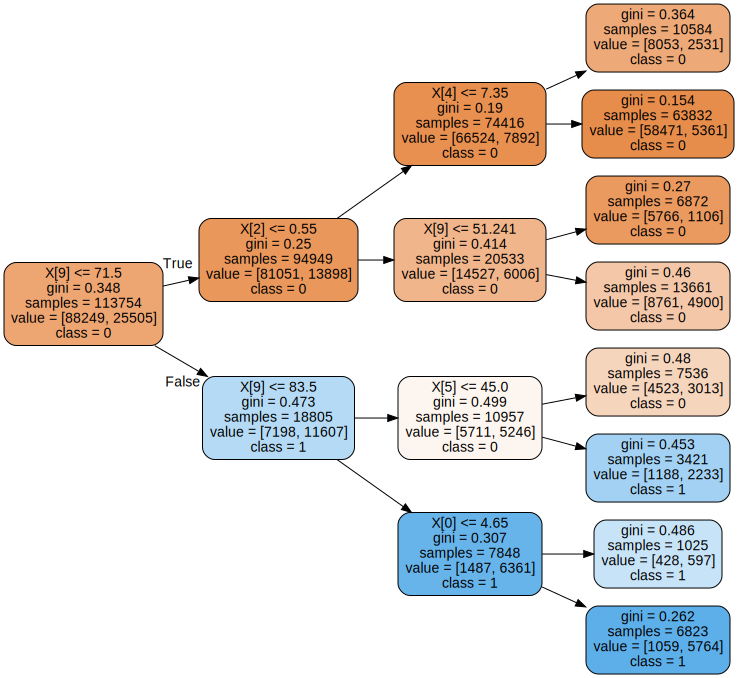

In [14]:
# Select data for modeling
X=df[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 
      'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',  
      'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainTodayFlag']]
y=df['RainTomorrowFlag'].values

# Fit the model and display results
X_train, X_test, y_train, y_test, clf, graph = fitting(X, y, 'gini', 'best', 
                                                       mdepth=3, 
                                                       clweight=None,
                                                       #clweight={0:0.7, 1:0.3}, 
                                                       minleaf=1000)

# Plot the tree graph
graph

# Save tree graph to a PDF
#graph.render('Decision_Tree_all_vars_gini')

##### List feature importance

In [15]:
list(zip(X.columns, clf.feature_importances_))

[('MinTemp', 0.011905413912772486),
 ('MaxTemp', 0.0),
 ('Rainfall', 0.10859346841045854),
 ('Evaporation', 0.0),
 ('Sunshine', 0.0424186467667312),
 ('WindGustSpeed', 0.02921492613556136),
 ('WindSpeed9am', 0.0),
 ('WindSpeed3pm', 0.0),
 ('Humidity9am', 0.0),
 ('Humidity3pm', 0.8078675447744765),
 ('Pressure9am', 0.0),
 ('Pressure3pm', 0.0),
 ('Cloud9am', 0.0),
 ('Cloud3pm', 0.0),
 ('Temp9am', 0.0),
 ('Temp3pm', 0.0),
 ('RainTodayFlag', 0.0)]

### Step 5 - Build a model with 2 features using Gini

*************** Tree Summary ***************
Classes:  [0 1]
Tree Depth:  3
No. of leaves:  8
No. of features:  2
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Accuracy Score:  0.828439818559021
              precision    recall  f1-score   support

           0       0.84      0.97      0.90     22067
           1       0.76      0.34      0.47      6372

    accuracy                           0.83     28439
   macro avg       0.80      0.65      0.68     28439
weighted avg       0.82      0.83      0.80     28439

--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.8278214392460924
              precision    recall  f1-score   support

           0       0.83      0.97      0.90     88249
           1       0.76      0.34      0.47     25505

    accuracy                           0.83    113754
   macro avg       0.80      0.65     

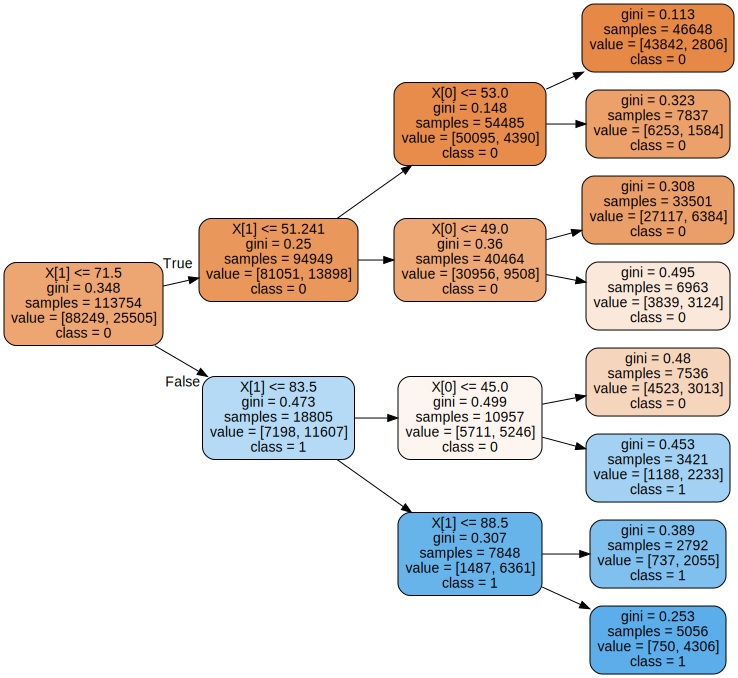

In [16]:
# Select data for modeling
X=df[['WindGustSpeed', 'Humidity3pm']]
y=df['RainTomorrowFlag'].values

# Fit the model and display results
X_train, X_test, y_train, y_test, clf, graph = fitting(X, y, 'gini', 'best', 
                                                       mdepth=3, 
                                                       clweight=None, 
                                                       minleaf=1000)

# Plot the tree graph
graph

# Save tree graph to a PDF
#graph.render('Decision_Tree_2vars_gini')

##### Plot a 3D graph

You can ignore sklearn warning as it does not affect the model or visualization

In [18]:
fig = Plot_3D(X, X_test, y_test, clf, x1='WindGustSpeed', x2='Humidity3pm', mesh_size=1, margin=1)
#fig.write_html('Decision_Tree_2vars_gini.html')

/Users/solclover/opt/anaconda3/envs/saulenv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



### Step 6 - Build a model with 2 features using Entropy

In [25]:
# Select data for modeling
X=df[['WindGustSpeed', 'Humidity3pm']]
y=df['RainTomorrowFlag'].values

# Fit the model and display results
X_train, X_test, y_train, y_test, clf, graph = fitting(X, y, 'entropy', 'best', 
                                                       mdepth=3, 
                                                       clweight=None, 
                                                       minleaf=1000)

# Plot the tree graph
#graph

# Save tree graph to a PDF
#graph.render('Decision_Tree_2vars_entropy')

*************** Tree Summary ***************
Classes:  [0 1]
Tree Depth:  3
No. of leaves:  8
No. of features:  2
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Accuracy Score:  0.8301628045993178
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     22067
           1       0.70      0.43      0.53      6372

    accuracy                           0.83     28439
   macro avg       0.77      0.69      0.71     28439
weighted avg       0.82      0.83      0.81     28439

--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.828340102326072
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     88249
           1       0.69      0.42      0.52     25505

    accuracy                           0.83    113754
   macro avg       0.77      0.68     

##### Plot a 3D graph

In [21]:
#fig = Plot_3D(X, X_test, y_test, clf, x1='WindGustSpeed', x2='Humidity3pm', mesh_size=1, margin=1)
#fig.write_html("Decision_Tree_2vars_entropy.html")

### Step 7 - Build a model with 2 features using Gini and unlimited tree depth

In [23]:
# Select data for modeling
X=df[['WindGustSpeed', 'Humidity3pm']]
y=df['RainTomorrowFlag'].values

# Fit the model and display results
X_train, X_test, y_train, y_test, clf, graph = fitting(X, y, 'gini', 'best', 
                                                       mdepth=None, 
                                                       clweight=None, 
                                                       minleaf=1000)

# Plot the tree graph
#graph

# Save tree graph to a PDF
#graph.render('Decision_Tree_2vars_gini_maxdepth')

*************** Tree Summary ***************
Classes:  [0 1]
Tree Depth:  10
No. of leaves:  82
No. of features:  2
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Accuracy Score:  0.8335032877386688
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     22067
           1       0.73      0.40      0.52      6372

    accuracy                           0.83     28439
   macro avg       0.79      0.68      0.71     28439
weighted avg       0.82      0.83      0.81     28439

--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.8316982259964485
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     88249
           1       0.73      0.40      0.52     25505

    accuracy                           0.83    113754
   macro avg       0.79      0.68  

##### Plot a 3D graph

In [24]:
fig = Plot_3D(X, X_test, y_test, clf, x1='WindGustSpeed', x2='Humidity3pm', mesh_size=1, margin=1)
#fig.write_html('Decision_Tree_2vars_gini_maxdepth.html')

/Users/solclover/opt/anaconda3/envs/saulenv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



# End of Program